In [1]:
import json
import cv2 as cv
import pickle as pkl
from typing import Dict, List
import numpy as np
from matplotlib import pyplot as plt
import os, sys
import librosa

from scipy import stats, spatial, ndimage
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/Gaze_project")
from Signal_processing_utils import intensity_from_signal, pitch_from_signal, sparse_key_smoothing, laplacian_smoothing
from Speech_Data_util import Sentence_word_phone_parser
from prototypes.InputDataStructures import Dietic_Conversation_Gaze_Scene_Info
from prototypes.MVP.MVP_static_saliency_list import ObjectBasedFixSaliency
from prototypes.MVP.MVP_Aversion_saliency_list import AversionSignalDrivenSaliency, CTSAversionSignalDrivenSaliency
from prototypes.MVP.MVP_look_at_point_planner import HabituationBasedPlanner, RandomPlanner, PartnerHabituationPlanner
from prototypes.MVP.MVP_eye_head_driver import HeuristicGazeMotionGenerator
from prototypes.MVP.MVP_Aversion_saliency_list import Base_Static_Saliency_List
from prototypes.EyeCatch.Saccade_model_with_internal_model import *
from prototypes.Gaze_aversion_prior.Heuristic_model import *
from prototypes.Boccignone2020.Gaze_target_planner import Scavenger_based_planner
from prototypes.Boccignone2020.Improved_gaze_target_planner import Scavenger_planner_with_nest, Scavenger_planner_simple 
from prototypes.JaliNeck.JaliNeck import NeckCurve
from prototypes.Gaze_aversion_prior.Ribhav_model import predict_aversion
from prototypes.InputDataStructures import AgentInfo, TurnTakingData
from prototypes.MVP.MVP_gaze_path_planner import Responsive_planner_simple
from multimatch import compute as get_multimatch
import pickle
import math
from datetime import datetime, timezone
import scipy.stats as ss
from Signal_processing_utils import interpolate1D, runEuro
import numpy as np
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport prototypes.InputDataStructures
%aimport Signal_processing_utils
%aimport Speech_Data_util
%aimport prototypes.MVP.MVP_static_saliency_list
%aimport prototypes.EyeCatch.Saccade_model_with_internal_model
%aimport prototypes.InputDataStructures
%aimport prototypes.Jin2019.EyeHeadDecomposition
%aimport prototypes.Optimization_based_head_eye_seperator.Baseline_optimization
%aimport prototypes.Boccignone2020.Improved_gaze_target_planner
%aimport prototypes.MVP.MVP_gaze_path_planner
%aimport prototypes.JaliNeck.JaliNeck
%aimport multimatch



In [5]:
# inputs
input_folder = "/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/"
input_folder = "F:/MASC/Ribhav_processed_dataset/"
# input_file = "Stranger Things’ Dacre Montgomery’s Insane _Billy_ Audition Tape ｜ GQ"
input_file = "Madelaine Petsch audition for The Prom"

input_scene_data_path = "/Users/evanpan/Documents/GitHub/Gaze_project/data/look_at_points/simplest_scene.json"
speaker_id = 1
shot_id = 1
turn_taking_threshold = 2
fps = 24
np.random.seed(speaker_id + shot_id)


### Gather The transcript and Audio From Jali (because it's more reliable)

In [4]:

input_file_no_space = "_".join(input_file.split(" "))
# input_file_no_space = "'" + input_file_no_space + "'"
shot_file_name = os.path.join(os.path.join(os.path.join(input_folder, "shots"), input_file), "shot_cuts.json")
video_path = os.path.join(*[input_folder, "video", input_file+".mp4"])
audio_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.wav".format(shot_id, 1))
audio_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.wav".format(shot_id, 2))
script_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.txt".format(shot_id, 1))
script_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.txt".format(shot_id, 2))
praatoutput_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}_PraatOutput.txt".format(shot_id, 1))
praatoutput_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}_PraatOutput.txt".format(shot_id, 2))
head_direction_json_path = os.path.join(*[input_folder, "pose", input_file+".pkl"])
gaze_direction_json_path = os.path.join(*[input_folder, "L2CSNet", input_file+".json"])
landmarks_mediapipe_json_path = os.path.join(*[input_folder, "faces", input_file+" faces.pkl"])
scene_file_out_location = os.path.join(*[input_folder, "annotated_scene", input_file+".json"])
animation_file_path = os.path.join(*[input_folder, "outputs", input_file+".pkl"])
animation_file_gaze_deploy_path = os.path.join(*[input_folder, "outputs", input_file+"_gaze_deploy.pkl"])
animation_file_static_salience_path = os.path.join(*[input_folder, "outputs", input_file+"_static_salience_map.pkl"])
animation_file_stare_location = os.path.join(*[input_folder, "outputs", input_file+"_stare.pkl"])

# out_location = "/Users/evanpan/Documents/GitHub/Gaze_project/data/look_at_points/prototype2p2.pkl"
# out_location = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/data/look_at_points/prototype2p2.pkl"

sementic_script_1 = Sentence_word_phone_parser(praatoutput_1_path, script_1_path)
# sementic_script_1.get_turns(turn_taking_threshold)
sementic_script_2 = Sentence_word_phone_parser(praatoutput_2_path, script_2_path)
# sementic_script_2.get_turns(turn_taking_threshold)
audio_1, sr= librosa.load(audio_1_path, sr=44100)
audio_2, sr= librosa.load(audio_2_path, sr=44100)
agentScene1 = AgentInfo(scene_file_out_location, wonder=False)
agentScene2 = AgentInfo(scene_file_out_location, wonder=False)

NameError: name 'scene_data_path' is not defined

# Load video info (From annotation)

In [7]:
# load head angle data
all_head_data = pkl.load(open(head_direction_json_path, "rb"))
head_angle_data = all_head_data["HEAD"]
head_rotmat_per_frame = head_angle_data["ROTMAT"]
head_bbox_per_frame = all_head_data["BBOX"] # this is largely useless 
head_angle_per_frame = []
neutral_position = np.array([0, 0, 100])
for i in range(0, head_rotmat_per_frame.shape[0]):
    pos = head_rotmat_per_frame[i] @ neutral_position
    head_angle_per_frame.append(rotation_angles_frome_positions(pos[:]))
head_angle_per_frame = np.array(head_angle_per_frame)
# getting rotation angle in z direction
neutral_position2 = np.array([0, 100, 0])
head_angle_z_per_frame = []
for i in range(0, head_rotmat_per_frame.shape[0]):
    pos = head_rotmat_per_frame[i] @ neutral_position2
    pos = np.array([pos[1], pos[2], pos[0]])
    head_angle_z_per_frame.append(rotation_angles_frome_positions(pos)[1])
head_angle_xy_per_frame = np.array(head_angle_per_frame)
head_angle_z_per_frame = np.expand_dims(np.array(head_angle_z_per_frame), axis=1)
head_angle_per_frame = np.concatenate([head_angle_xy_per_frame, head_angle_z_per_frame], axis=1)

# load gaze data (L2CS)
all_gaze_data = pkl.load(open(gaze_direction_json_path, "rb"))
gaze_angle_data = all_gaze_data["RAW_GAZE"]
gaze_angle_per_frame = gaze_angle_data["EULER"]
gaze_rotmat_per_frame = gaze_angle_data["ROTMAT"]
blinks = all_head_data["BLINKS"]
gaze_vec = np.array([0, 0, 100])
eye_angle_per_frame = []
for i in range(0, gaze_rotmat_per_frame.shape[0]):
    eye_line = gaze_rotmat_per_frame[i] @ gaze_vec
    eye_line = eye_line / eye_line[2] * 100
    eye_angle_per_frame.append(eye_line)
eye_angle_per_frame = np.array(eye_angle_per_frame)
eye_angle_per_frame = rotation_angles_frome_positions(eye_angle_per_frame[:])

# time vector
video_ts = np.arange(0, eye_angle_per_frame.shape[0])/fps
gt_interp = interp1d(video_ts, eye_angle_per_frame, axis=0)

# Load generated motion

In [8]:
def load_animation(filepath):
    output_json = pkl.load(open(filepath, "rb"))
    predicted_eye_positions = output_json["eye_frames"] # ek is in local space
    predicted_head_angles = output_json["head_frames"] # hk are just angles
    ms = output_json["micro_saccade"]
    neck = output_json["other_neck"]
    envelope = output_json["envelope"]
    return predicted_eye_positions, predicted_head_angles, ms, neck, envelope
# load file
ek, hk, ms, neck, envelope = load_animation(animation_file_path)
gp_ek, gp_hk, gp_ms, gp_neck, gp_envelope = load_animation(animation_file_gaze_deploy_path)
ss_ek, ss_hk, ss_ms, ss_neck, ss_envelope = load_animation(animation_file_static_salience_path)
st_ek, st_hk, st_ms, st_neck, st_envelope = load_animation(animation_file_stare_location)
ek = np.array(ek)[0]
ts = ek[:, 0]
ek_interp = interp1d(ts, rotation_angles_frome_positions(ek[:, 1:]), axis=0, bounds_error=False)

gp_ek = np.array(gp_ek)[0]
gp_ts = gp_ek[:, 0]
gp_ek_interp = interp1d(gp_ts, rotation_angles_frome_positions(gp_ek[:, 1:]), axis=0, bounds_error=False)

ss_ek = np.array(ss_ek)[0]
ss_ts = ss_ek[:, 0]
ss_ek_interp = interp1d(ss_ts, rotation_angles_frome_positions(ss_ek[:, 1:]), axis=0, bounds_error=False)

st_ek = np.array(st_ek)[0]
st_ts = st_ek[:, 0]
st_ek_interp = interp1d(st_ts, rotation_angles_frome_positions(st_ek[:, 1:]), axis=0, bounds_error=False)

# MSE evaluation

In [10]:
evaluation_fps = 24
start = int(np.round(ss_ts[0] * evaluation_fps))
end = int(np.round((ss_ts[-1] - 5) * evaluation_fps))
times = np.arange(start, end) /evaluation_fps

# get aligned look-at-point positions
gt = gt_interp(times)
method_mine = ek_interp(times)
method_gd = gp_ek_interp(times)
method_ss = ss_ek_interp(times)
method_st = st_ek_interp(times)
# get the MSE errors
mse_mine = np.linalg.norm(gt - method_mine) / gt.shape[0]
mse_gd = np.linalg.norm(gt - method_gd) / gt.shape[0]
mse_static = np.linalg.norm(gt - method_ss) / gt.shape[0]
mse_stare = np.linalg.norm(gt - method_st)/ gt.shape[0]

print("MSE error of the just staring at conversation partner is: ", mse_stare)
print("MSE error of the gaze-deploy system with a static saliency map is: ", mse_static)
print("MSE error of the gaze-deploy system with the turn taking salience map is : ", mse_gd)
print("MSE error of the proposed system is: ", mse_mine)

MSE error of the just staring at conversation partner is:  0.2831221240527889
MSE error of the gaze-deploy system with a static saliency map is:  0.3375582080131861
MSE error of the gaze-deploy system with the turn taking salience map is :  0.4874721740238694
MSE error of the proposed system is:  0.3750286288089286


# Gaze target Accuracy

In [11]:
# get aligned look-at-point positions
gt = gt_interp(times)
method_mine = ek_interp(times)
method_gd = gp_ek_interp(times)
method_ss = ss_ek_interp(times)
method_st = st_ek_interp(times)

# get the cluster centers
centers = agentScene1.get_all_positions(coordinate_space="local")
centers = rotation_angles_frome_positions(centers)

# given raw datas, cluster them to the cluster centers as per distance
def get_gaze_targets(raw_data, centers):
    out = []
    for i in range(0, raw_data.shape[0]):
        pt = raw_data[i:i+1]
        dist = np.linalg.norm(pt - centers, axis=1)
        out.append(np.argmin(dist))
    return np.array(out)

# get the clustering
gt_cluster = get_gaze_targets(gt, centers)
mine_cluster = get_gaze_targets(method_mine, centers)
gd_cluster = get_gaze_targets(method_gd, centers)
ss_cluster = get_gaze_targets(method_ss, centers)
st_cluster = get_gaze_targets(method_st, centers)


# compute accuracy
mine_accuracy = np.sum(np.where(gt_cluster == mine_cluster, 1, 0) / gt_cluster.shape[0])
gd_accuracy = np.sum(np.where(gt_cluster == gd_cluster, 1, 0) / gt_cluster.shape[0])
ss_accuracy = np.sum(np.where(gt_cluster == ss_cluster, 1, 0) / gt_cluster.shape[0])
st_accuracy = np.sum(np.where(gt_cluster == st_cluster, 1, 0) / gt_cluster.shape[0])

print("Cluster Accuracy of the just staring at conversation partner is: ", st_accuracy)
print("Cluster Accuracy of the gaze-deploy system with a static saliency map is: ", ss_accuracy)
print("Cluster Accuracy of the gaze-deploy system with the turn taking salience map is : ", gd_accuracy)
print("Cluster Accuracy of the proposed system is: ", mine_accuracy)

Cluster Accuracy of the just staring at conversation partner is:  0.773821299043851
Cluster Accuracy of the gaze-deploy system with a static saliency map is:  0.699967029343884
Cluster Accuracy of the gaze-deploy system with the turn taking salience map is :  0.37619518628420706
Cluster Accuracy of the proposed system is:  0.5654467523903726


# Aversion Prediction Accuracy

In [19]:
# get aligned look-at-point positions
gt = gt_interp(times)
method_mine = ek_interp(times)
method_gd = gp_ek_interp(times)
method_ss = ss_ek_interp(times)
method_st = st_ek_interp(times)

# get the cluster centers
centers = agentScene1.get_all_positions(coordinate_space="local")
centers = rotation_angles_frome_positions(centers)

# given raw datas, cluster them to the cluster centers as per distance
def get_gaze_targets(raw_data, centers):
    out = []
    for i in range(0, raw_data.shape[0]):
        pt = raw_data[i:i+1]
        dist = np.linalg.norm(pt - centers, axis=1)
        out.append(np.argmin(dist))
    return np.array(out)

# get the clustering
gt_cluster = get_gaze_targets(gt, centers)
mine_cluster = get_gaze_targets(method_mine, centers)
gd_cluster = get_gaze_targets(method_gd, centers)
ss_cluster = get_gaze_targets(method_ss, centers)
st_cluster = get_gaze_targets(method_st, centers)


# binary clustering
conversation_partner_id = len(agentScene1.object_interest)
gt_binary_cluster = np.where(conversation_partner_id == gt_cluster, 1, 0)
mine_binary_cluster = np.where(conversation_partner_id == mine_cluster, 1, 0)
gd_binary_cluster = np.where(conversation_partner_id == gd_cluster, 1, 0) 
ss_binary_cluster = np.where(conversation_partner_id == ss_cluster, 1, 0) 
st_binary_cluster = np.where(conversation_partner_id == st_cluster, 1, 0)

# compute accuracy
mine_accuracy = np.sum(np.where(gt_binary_cluster == mine_binary_cluster, 1, 0) / gt_cluster.shape[0])
gd_accuracy = np.sum(np.where(gt_binary_cluster == gd_binary_cluster, 1, 0) / gt_cluster.shape[0])
ss_accuracy = np.sum(np.where(gt_binary_cluster == ss_binary_cluster, 1, 0) / gt_cluster.shape[0])
st_accuracy = np.sum(np.where(gt_binary_cluster == st_binary_cluster, 1, 0) / gt_cluster.shape[0])

print("Cluster Accuracy of the just staring at conversation partner is: ", st_accuracy)
print("Cluster Accuracy of the gaze-deploy system with a static saliency map is: ", ss_accuracy)
print("Cluster Accuracy of the gaze-deploy system with the turn taking salience map is : ", gd_accuracy)
print("Cluster Accuracy of the proposed system is: ", mine_accuracy)

Cluster Accuracy of the just staring at conversation partner is:  0.773821299043851
Cluster Accuracy of the gaze-deploy system with a static saliency map is:  0.7121661721068249
Cluster Accuracy of the gaze-deploy system with the turn taking salience map is :  0.4833498186613914
Cluster Accuracy of the proposed system is:  0.614573030003297


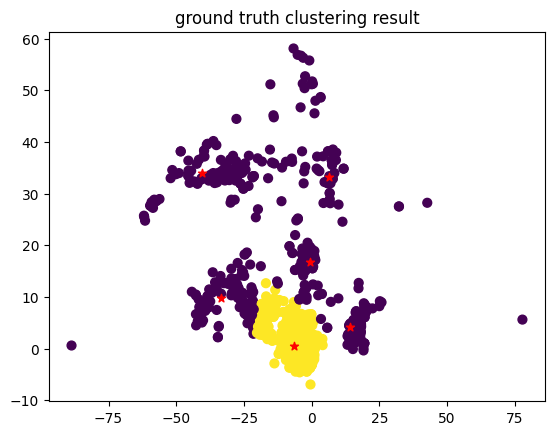

In [22]:
from matplotlib import pyplot as plt
plt.title("ground truth clustering result")
plt.scatter(gt[:, 0], gt[:, 1], c=gt_binary_cluster, s=40, cmap='viridis');  
plt.scatter(centers[:, 0], centers[:, 1], marker="*", c="r")
plt.show()

# Multi-match Similarity Measures

In [24]:
# get scan path
gt = gt_interp(times)
method_mine = ek_interp(times)
method_gd = gp_ek_interp(times)
method_ss = ss_ek_interp(times)
method_st = st_ek_interp(times)

def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.2):
    start = 0
    window = []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)

    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        while disp <= dispersion_threshold:
            disp = dispersion(y[window])
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
            
        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
    fixations = np.array(fixations)
    return fixations
gt_fixation = dispersion_filtering(times, gt)
mine_fixation = dispersion_filtering(times, method_mine)
gd_fixation = dispersion_filtering(times, method_gd)
ss_fixation = dispersion_filtering(times, method_ss)
st_fixation = dispersion_filtering(times, method_st)
st_fixation = np.concatenate([st_fixation, st_fixation + np.array([[0, 0 ,0]]), st_fixation + np.array([[0, 0 ,0]])], axis=0)

doprint = True
print("===== The multimatch score for just stare: ")
out_st = get_multimatch(gt_fixation, st_fixation, doprint=doprint)
print("===== The multimatch score for random: ")
out_ss = get_multimatch(gt_fixation, ss_fixation, doprint=doprint)
print("===== The multimatch score for gaze deploy: ")
out_gd = get_multimatch(gt_fixation, gd_fixation, doprint=doprint)
print("===== The multimatch score for mine: ")
out_proposed = get_multimatch(gt_fixation, mine_fixation, doprint=doprint)



===== The multimatch score for just stare: 
Vector similarity = 0.9961455948028479
Direction similarity = 0.551662782794586
Length similarity = 0.9922911896056958
Position similarity = 0.9847567602710122
Duration similarity = 0.4185285053929122
===== The multimatch score for random: 
Vector similarity = 0.9941107074870987
Direction similarity = 0.5170796071969874
Length similarity = 0.9950441821086976
Position similarity = 0.8930765447360232
Duration similarity = 0.9972401103955841
===== The multimatch score for gaze deploy: 
Vector similarity = 0.985748022941844
Direction similarity = 0.6815007760940295
Length similarity = 0.9851644175654227
Position similarity = 0.924311637136845
Duration similarity = 0.9954065227377126
===== The multimatch score for mine: 
Vector similarity = 0.9925358733627676
Direction similarity = 0.5412002831248122
Length similarity = 0.9936145977406341
Position similarity = 0.9769755027521897
Duration similarity = 0.9963243738009673


In [30]:
out_proposed

[0.9925358733627676,
 0.5412002831248122,
 0.9936145977406341,
 0.9769755027521897,
 0.9963243738009673]

# Scan-match Similarity Measures

In [144]:
import ScanMatchPy
# get aligned look-at-point positions
gt = gt_interp(times)
method_mine = ek_interp(times)
method_gd = gp_ek_interp(times)
method_ss = ss_ek_interp(times)
method_st = st_ek_interp(times)

# get the cluster centers
centers = agentScene1.get_all_positions(coordinate_space="local")
centers = rotation_angles_frome_positions(centers)

# given raw datas, cluster them to the cluster centers as per distance
def get_gaze_targets(raw_data, centers):
    out = []
    for i in range(0, raw_data.shape[0]):
        pt = raw_data[i:i+1]
        dist = np.linalg.norm(pt - centers, axis=1)
        out.append(np.argmin(dist))
    return np.array(out)

# get the clustering
gt_cluster = get_gaze_targets(gt, centers)
mine_cluster = get_gaze_targets(method_mine, centers)
gd_cluster = get_gaze_targets(method_gd, centers)
ss_cluster = get_gaze_targets(method_ss, centers)
st_cluster = get_gaze_targets(method_st, centers)

print(st_cluster.shape)

ModuleNotFoundError: No module named 'ScanMatchPy'